# Main notebook for simulation experiments

## Imports

In [4]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import coclusterSVD as ccSVD
import bicluster as bc
import submatrix as sm
import importlib 

def generate(seed, num_bicluster, num_pool, M, N, m, n):
    # psedo random vector with fixed seed, ori(0), ori(1), ... ori(num_bicluster-1)
    ori = np.random.RandomState(seed=seed).rand(num_bicluster, num_pool)

    # scale = np.random.RandomState(seed+2).rand(num_bicluster)

    # p is a list, p[i] is a n[i]-length vector, as the base of bicluster i
    p = []
    for i in range(num_bicluster):
        p.append(ori[i][:n[i]])

    for i in range(num_bicluster):
        assert len(p[i]) == n[i]

    A = np.zeros((M, N))

    # A(0:n(0), 0:m(0)) = p(0)
    # A(n(0):n(0)+n(1), 0:m(1)) = p(1)
    # ...

    startx = starty = 0
    label_matrix = np.zeros((M, N)) # value is the label of bicluster
    for i in range(num_bicluster):
        for j in range(m[i]):
            A[startx:startx+n[i], starty+j] = p[i] * np.random.RandomState(i*2000 + j).rand()
            label_matrix[startx:startx+n[i], starty+j] = i
        startx += n[i]
        starty += m[i]

    # show A as a heatmap
    # plt.imshow(A, cmap='hot', interpolation='nearest')
    # plt.show()

    # permutation of M and N
    permx = np.random.RandomState(seed).permutation(M)
    permy = np.random.RandomState(seed+1).permutation(N)

    # print permx and permy
    # print('permx: ', permx)
    # print('permy: ', permy)

    # permute A
    B = A[permx, :]
    B = B[:, permy]

    label_matrix = label_matrix[permx, :]
    label_matrix = label_matrix[:, permy]

    # B = A + rand * 0.1 * average(A)
    # B = B + np.random.RandomState(seed).rand(M, N) * 0.01 * np.mean(A)

    # show B as a heatmap

    return B, permx, permy, A, label_matrix


## Generate Big Matrix ($M \times N$)

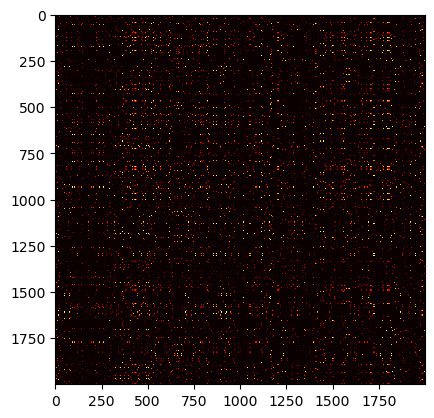

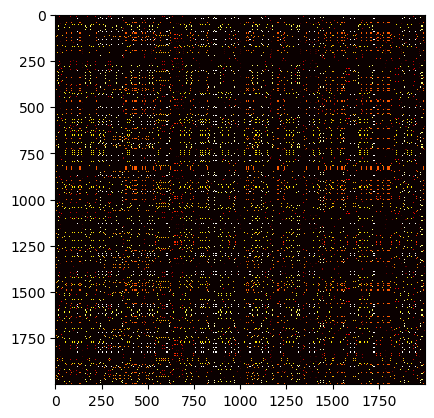

In [7]:
seed = 42
num_pool = 200 # as random pool for bases of biclusters
# num_upper_bound = 20 # upper bound of number of biclusters
# num_bicluster = np.random.RandomState(seed+1).randint(1, num_upper_bound, 1)[0] # number of biclusters
num_bicluster = 15
# random n(0) n(1) n(2) ... n(num_bicluster-1) as the length of each bicluster base vector
n = np.random.RandomState(seed=seed).randint(
    num_pool/5, num_pool, num_bicluster)


# m is the height of biclusters
m = np.random.RandomState(
    seed=seed+1).randint(num_pool/5, num_pool, num_bicluster)
# m = np.ones(num_bicluster, dtype=int) * 1000
# n = np.ones(num_bicluster, dtype=int) * 1000

M = 2000
N = 2000
B, permx, permy, A, labelMatrix = generate(
        seed=seed, num_pool=num_pool, num_bicluster=num_bicluster, M=M, N=N, m=m, n=n
    )

# print('permx: ', permx)
# print('permy: ', permy)

plt.imshow(B, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(labelMatrix, cmap='hot', interpolation='nearest')
plt.show()

## Generate submatrix list (and labelMatList)

(500, 500)


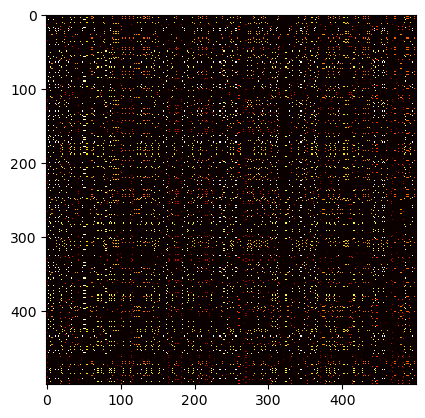

In [6]:
partition : int = 4

sizex = M // partition
sizey = N // partition

importlib.reload(sm)
subMatList = []
labelMatList = []
for i in range(partition):
    for j in range(partition):
        subMatList.append(sm.submatrix(B[i*sizex:(i+1)*sizex, j*sizey:(j+1)*sizey], i*sizex, j*sizey))
        labelMatList.append(sm.submatrix(labelMatrix[i*sizex:(i+1)*sizex, j*sizey:(j+1)*sizey], i*sizex, j*sizey))

print(labelMatList[0].matrix.shape)
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')
plt.show()


## Coclustering on each submatrix

In [7]:
importlib.reload(ccSVD)
importlib.reload(bc)
# ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15)

biclusterList = []
for item in subMatList:
    # concat the biclusterList
    biclusterList += ccSVD.coclusterAtom(X=item, tor=10e-2, k = 15, M=M, N=N)

print('biclusterList.length: ', len(biclusterList))

biclusterList.length:  63


In [8]:
# while biclusterList not empty
from coclusterSVD import isBiclusterIntersectGeneral
importlib.reload(ccSVD)
importlib.reload(bc)


count = 0
flag = True # if flag is True, then the item is not merged
while len(biclusterList) > 0:
    count += 1
    item : bc.bicluster = biclusterList.pop(0)
    for item_c in biclusterList:
        # concat the biclusterList
        # if ccSVD.isBiclusterIntersectGeneral(bc1=item, bc2=item_c):
        if True:
            # newRowIdx is OR(rowIdx, rowIdx_c)
            # e.g. rowIdx = [True, False, True], rowIdx_c = [False, True, True], newRowIdx = [True, True, True]
            newRowIdx = np.logical_or(item.row_idx, item_c.row_idx)
            newColIdx = np.logical_or(item.col_idx, item_c.col_idx)
            newScore = ccSVD.score(B, newRowIdx, newColIdx)
            print('newScore: ', newScore)
            # if newScore < item.score + item_c.score or newScore < 0.01:
            if newScore < item.score + item_c.score or newScore < 0.1:
                # replace item_c with new bicluster
                biclusterList.remove(item_c)
                biclusterList.append(bc.bicluster(newRowIdx, newColIdx, newScore))
                count = 0
                flag = False
                break
    if flag:
        biclusterList.append(item)
        flag = True
    if count > 2 * len(biclusterList):
        break
    
print('biclusterList.length: ', len(biclusterList))
            

newScore:  0.0
newScore:  0.0
newScore:  0.43301176619902504
newScore:  0.7897796621156905
newScore:  0.8496179324245721
newScore:  0.8506414514505259
newScore:  0.5217296940792644
newScore:  0.5014167330792059
newScore:  0.7061170607317215
newScore:  0.7023956262455304
newScore:  0.7208426544406596
newScore:  0.7386556019551244
newScore:  0.4548199232413592
newScore:  0.4497505331377205
newScore:  0.4738931056552669
newScore:  0.47135826026235506
newScore:  0.4565633328029379
newScore:  0.46026224426297835
newScore:  0.45350501486963624
newScore:  0.47503411513937466
newScore:  0.460197853231073
newScore:  0.4576765869803826
newScore:  0.4535010154914515
newScore:  0.4490489188917215
newScore:  0.4673327360740328
newScore:  0.47506928091702083
newScore:  0.4586502298157987
newScore:  0.8476155804288403
newScore:  0.47287373884927497
newScore:  0.8471802659009817
newScore:  0.8464580059467381
newScore:  0.6433337475890792
newScore:  0.6434266704413345
newScore:  0.5356426712579478
newS

In [ ]:
# print all length of biclusters
for item in biclusterList:
    # print('row length: ', np.sum(item.row_idx))
    # print('row_size: ', item.row_idx.size)
    # print('col length: ', np.sum(item.col_idx))
    # print('col_size: ', item.col_idx.size)
    print('score: ', item.score)
    print('row_idx: ', item.row_idx)
    print('col_idx: ', item.col_idx)
    print('------------------')
    

score:  0.0
row_idx:  [False False False ... False False False]
col_idx:  [False False False ... False False False]
------------------
score:  0.0
row_idx:  [False False False ... False False False]
col_idx:  [False False False ...  True  True  True]
------------------
score:  0.0
row_idx:  [False False False ... False False False]
col_idx:  [False False False ... False False False]
------------------
score:  0.0
row_idx:  [False False False ... False False False]
col_idx:  [False False False ... False False False]
------------------
score:  0.0
row_idx:  [False False False ... False False False]
col_idx:  [False False False ...  True  True  True]
------------------
score:  1.1102230246251565e-16
row_idx:  [False False False ... False False False]
col_idx:  [False False False ... False False False]
------------------
score:  0.0
row_idx:  [False False False ...  True  True  True]
col_idx:  [False False False ... False False False]
------------------
score:  0.0
row_idx:  [False False F

In [ ]:
# cluster1index = permx
testA = A[0:n[0], 0:m[0]]

# testI is all true with shape (n[0],)
# testJ is all true with shape (m[0],)
testI = np.ones(n[0], dtype=bool)
testJ = np.ones(m[0], dtype=bool)

testScore = ccSVD.score(testA, testI, testJ)
print('testScore: ', testScore)

testScore:  0.0


In [ ]:
# m[0]
# n[0]
print('m[0]: ', m[0])
print('n[0]: ', n[0])

# find range(0, n[0]) from permx and save it to IDX_I_one
# find range(0, m[0]) from permy and save it to IDX_J_one

IDX_I_one = permx[0:n[0]]
IDX_J_one = permy[0:m[0]]

# show limited to M // partition * N // partition submatrix
IDX_I_one = IDX_I_one[IDX_I_one < M // partition]
IDX_J_one = IDX_J_one[IDX_J_one < N // partition]

print('IDX_I_one: ', IDX_I_one)
print('IDX_J_one: ', IDX_J_one)

m[0]:  108
n[0]:  142
IDX_I_one:  [353  65  56 374 275 128  99  29 450 254 124 251  70 247 212 361 111 383
 324 368  69 478 281 210 297 429 239 256 382 352 494 393 464 366 306]
IDX_J_one:  [305 454 497  91 131 495 384 431 112  82  23  72 404 427 270 195  68]


## Work on one submatrix

### Get the small matrix

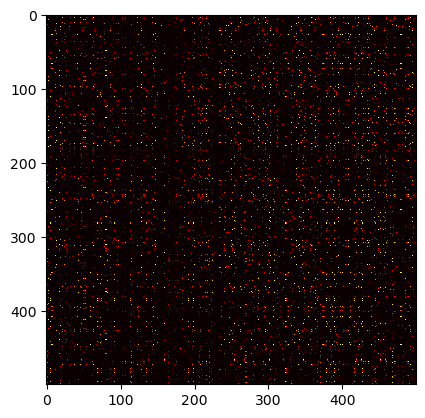

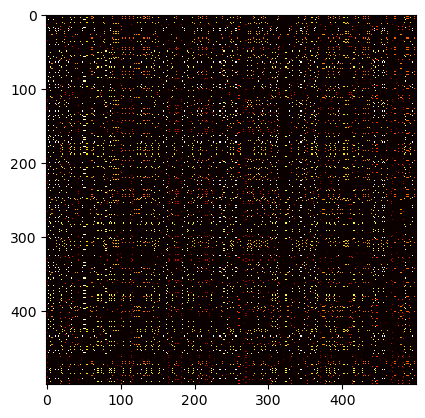

In [11]:
testB = subMatList[0]
testB_label = labelMatList[0]

plt.imshow(testB.matrix, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(testB_label.matrix, cmap='hot', interpolation='nearest')
plt.show()

In [13]:
ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15, M=M, N=N)
print('ans: ', ans)

ans:  [bicluster(row_idx=array([ True,  True,  True, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=-2.220446049250313e-16), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True,  True, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), 

/Users/zihanwu/miniforge3/envs/cocluster/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


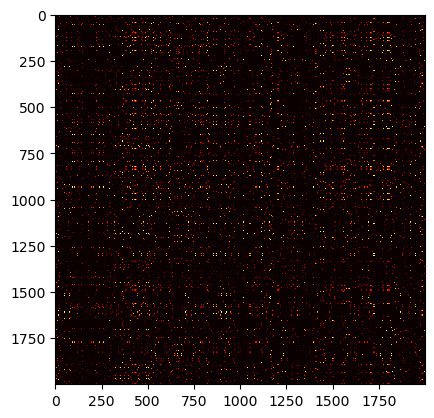

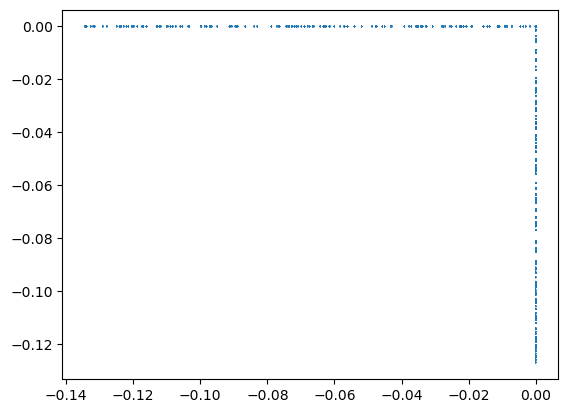

In [10]:
importlib.reload(ccSVD)
importlib.reload(bc)

# imshow B
plt.imshow(B, cmap='hot', interpolation='nearest')

U, S, Vh = np.linalg.svd(B, full_matrices=False)

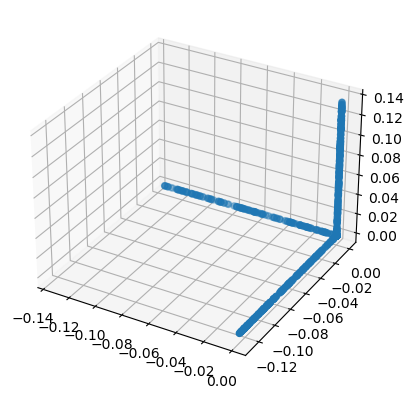

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming U3 is your matrix with 3 columns for x, y, z coordinates
x, y, z = U3[:, 0], U3[:, 1], U3[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()
